# Keras and Convolutional Neural Networks (CNNs)
https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/

In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import imutils
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

Using TensorFlow backend.


## Architecture
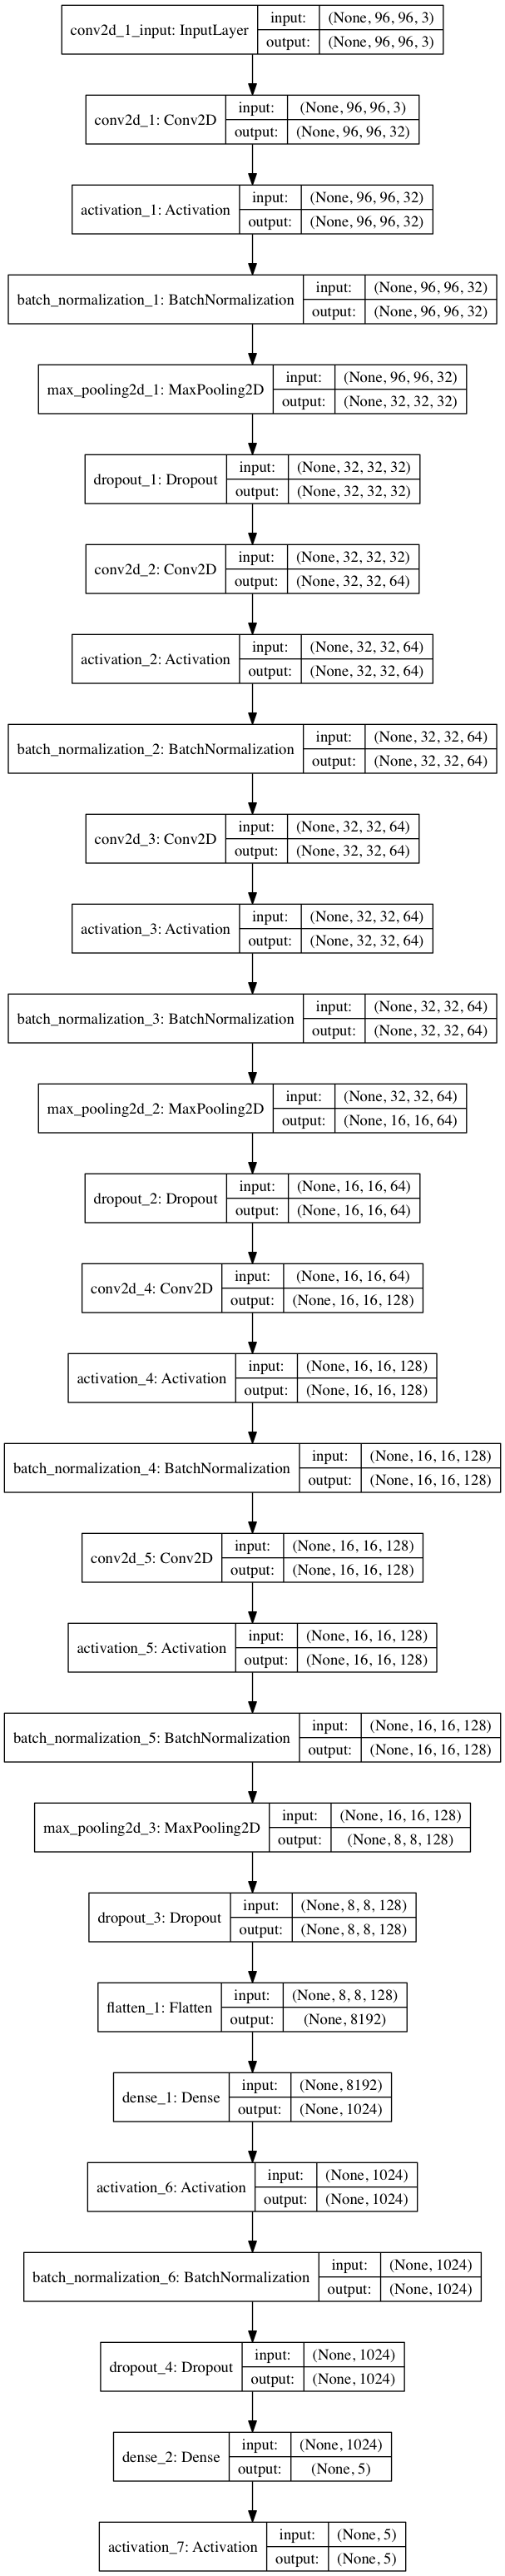

In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # Initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # If we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # First (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # Return the constructed network architecture
        return model

## Settings

In [3]:
dataset_path = 'dataset/'  # Path to input dataset (i.e., directory of images)
model_path = 'output/pokedex.model'  # Path to output model
labelbin_path = 'output/lb.pickle'  # Path to output label binarizer

EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

## Preprocessing

In [4]:
# Initialize the data and labels
data = []
labels = []

# Grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(42)
random.shuffle(imagePaths)

# Loop over the input images
for imagePath in imagePaths:
    # Load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
 
    # Extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
# Scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("Data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# Construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

Data matrix: 252.07MB


## Training

In [5]:
# Initialize the model
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2],
                            classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // BS,
                        epochs=EPOCHS, verbose=1)

Epoch 1/100
29/29 [==============================] - 9s 297ms/step - loss: 1.3637 - accuracy: 0.6404 - val_loss: 1.8649 - val_accuracy: 0.2650
Epoch 2/100
29/29 [==============================] - 8s 281ms/step - loss: 0.8078 - accuracy: 0.7481 - val_loss: 1.7017 - val_accuracy: 0.3162
Epoch 3/100
29/29 [==============================] - 9s 296ms/step - loss: 0.6330 - accuracy: 0.8058 - val_loss: 1.9845 - val_accuracy: 0.3974
Epoch 4/100
29/29 [==============================] - 9s 299ms/step - loss: 0.6984 - accuracy: 0.8080 - val_loss: 1.5190 - val_accuracy: 0.4829
Epoch 5/100
29/29 [==============================] - 8s 292ms/step - loss: 0.6434 - accuracy: 0.8024 - val_loss: 2.1232 - val_accuracy: 0.3462
Epoch 6/100
29/29 [==============================] - 9s 298ms/step - loss: 0.5740 - accuracy: 0.8222 - val_loss: 1.8752 - val_accuracy: 0.4744
Epoch 7/100
29/29 [==============================] - 8s 290ms/step - loss: 0.6790 - accuracy: 0.8135 - val_loss: 1.7456 - val_accuracy: 0.4872

Epoch 58/100
29/29 [==============================] - 9s 309ms/step - loss: 0.1914 - accuracy: 0.9323 - val_loss: 0.3484 - val_accuracy: 0.9060
Epoch 59/100
29/29 [==============================] - 9s 296ms/step - loss: 0.1533 - accuracy: 0.9467 - val_loss: 0.5903 - val_accuracy: 0.8419
Epoch 60/100
29/29 [==============================] - 9s 297ms/step - loss: 0.2589 - accuracy: 0.9156 - val_loss: 0.6409 - val_accuracy: 0.8590
Epoch 61/100
29/29 [==============================] - 9s 297ms/step - loss: 0.1861 - accuracy: 0.9501 - val_loss: 1.9473 - val_accuracy: 0.7051
Epoch 62/100
29/29 [==============================] - 9s 303ms/step - loss: 0.2694 - accuracy: 0.9201 - val_loss: 0.9704 - val_accuracy: 0.7521
Epoch 63/100
29/29 [==============================] - 9s 304ms/step - loss: 0.2012 - accuracy: 0.9312 - val_loss: 0.6751 - val_accuracy: 0.8632
Epoch 64/100
29/29 [==============================] - 9s 320ms/step - loss: 0.1975 - accuracy: 0.9312 - val_loss: 0.5230 - val_accuracy:

In [6]:
# Save the model to disk
model.save(model_path)

# Save the label binarizer to disk
f = open(labelbin_path, "wb")
f.write(pickle.dumps(lb))
f.close()

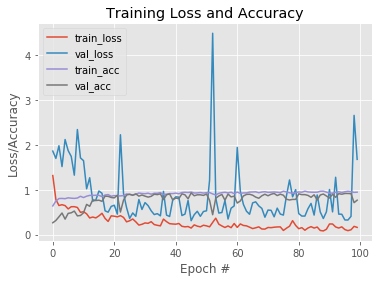

In [7]:
# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

## Test model

In [8]:
test_folder = 'examples'

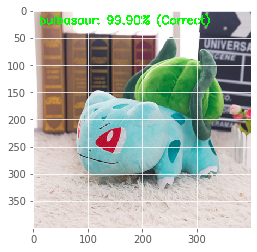

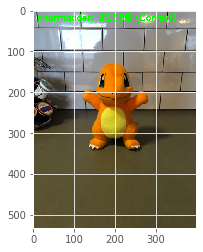

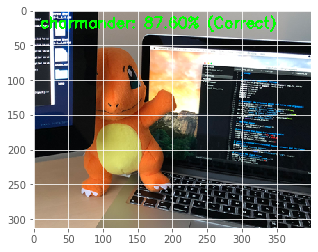

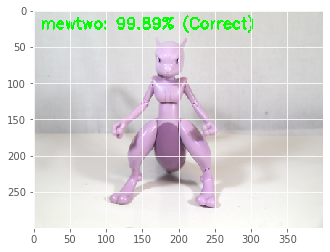

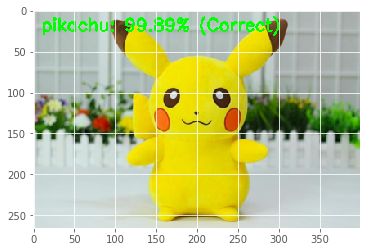

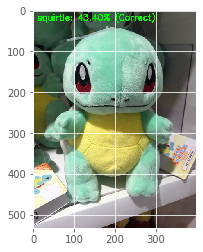

In [9]:
# Grab the image paths and randomly shuffle them
test_paths = sorted(list(paths.list_images(test_folder)))

# Load the trained convolutional neural network and the label binarizer
model = load_model(model_path)
lb = pickle.loads(open(labelbin_path, "rb").read())

for i in range(len(test_paths)):
    # Load the image
    image = cv2.imread(test_paths[i])
    output = image.copy()

    # Pre-process the image for classification
    image = cv2.resize(image, (96, 96))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # classify the input image
    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    
    # We'll mark our prediction as "correct" of the input image filename
    # contains the predicted label text (obviously this makes the
    # assumption that you have named your testing image files this way)
    filename = test_paths[i][test_paths[i].rfind(os.path.sep) + 1:]
    correct = "Correct" if filename.rfind(label) != -1 else "Incorrect"
    
    # Build the label and draw the label on the image
    label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
    output = imutils.resize(output, width=400)
    cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Show the output image
    plt.figure()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))